In [16]:
%pip install pandas 
%pip install python-dotenv
%pip install -U scikit-learn
%pip install sun_position_calculator
%pip install requests
%pip install docxtpl
%pip install matplotlib
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [17]:
#local models
from typing import Dict
from models.econometrics import Cost, Currency
from models.components import Component
from models.econometrics import Cost
from models.geometry import Orientation
from models.photovoltaic import Photovoltaic
import pandas as pd

In [18]:
#local env variables
from dotenv import dotenv_values
config = dotenv_values(".env.local")

# Building references

## Currencies values

In [19]:
import requests # type: ignore
import json
#currency values

# national units https://mindicador.cl/api
query_factor:requests.Response = requests.get('https://mindicador.cl/api',timeout=1000)
ratios_cl = json.loads(query_factor.text)
usd_clp:float = ratios_cl['dolar']['valor']
Cost.set_exchange(Currency.CLP,usd_clp)
Cost.set_exchange(Currency.UF,usd_clp/ratios_cl['uf']['valor']) # 1 dolar in UF
Cost.set_exchange(Currency.UTM,usd_clp/ratios_cl['utm']['valor']) # 1 dolar in Utm

# exchange rates https://app.freecurrencyapi.com/dashboard
query_exchange:requests.Response = requests.get(config["CURRENCY_API_KEY"],timeout=1000)

currency_ratios = json.loads(query_exchange.text)
Cost.set_exchange(Currency.EUR,currency_ratios['data']['EUR'])
Cost.set_exchange(Currency.GBP,currency_ratios['data']['GBP'])
Cost.set_exchange(Currency.BRL,currency_ratios['data']['BRL'])


set $1 Peso Chileno... on USD$0.00 
set $1 UF............. on USD$39.06 
set $1 UTM............ on USD$68.57 
set $1 Euro........... on USD$1.07 
set $1 Pound.......... on USD$1.25 
set $1 Real........... on USD$0.20 


## Address and general info🌎

In [40]:
#cspell:disable


#init proyect
from models.components import Tech
from models.geometry import GeoPosition
from models.inventory import Building, Project

project:Project = Project(
    title='Sistema Fotovoltaico OnGrid-Mixto',
    building = Building(
        geolocation=GeoPosition(latitude=-33.861702,longitude=-71.657839),
        name='Posta de Salud Rural Bucalemu',
        address='Ruta G-80-I km 30 sn, Localidad Bucalemu,\nSanto Domingo',
        city='Santo Domingo'),
    technology= [Tech.PHOTOVOLTAIC]
    )

project.weather.get_data()

api request URL https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M&community=RE&latitude=-33.861702&longitude=-71.657839&start=20230101&end=20231231&format=JSON


,date,T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M,year,month,day,hour
0,2023-01-01 00:00:00,14.20,0.0,0.0,None,None,2.73,2023,01,01,00
1,2023-01-01 01:00:00,13.96,0.0,0.0,None,None,2.96,2023,01,01,01
2,2023-01-01 02:00:00,13.66,0.0,0.0,None,None,2.99,2023,01,01,02
3,2023-01-01 03:00:00,13.34,0.0,0.0,None,None,3.09,2023,01,01,03
4,2023-01-01 04:00:00,13.16,0.0,0.0,None,None,3.15,2023,01,01,04
...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,15.40,0.0,0.0,None,None,4.58,2023,12,31,19
8756,2023-12-31 20:00:00,14.88,0.0,0.0,None,None,4.32,2023,12,31,20
8757,2023-12-31 21:00:00,14.48,0.0,0.0,None,None,3.64,2023,12,31,21
8758,2023-12-31 22:00:00,14.25,0.0,0.0,None,None,3.39,2023,12,31,22


# Integration 

## Energy Consumptions🔌

In [21]:
from models.consumption import ElectricityBill, Energetic
project.building.add_consumptions(description="main",energetic=Energetic.ELI,consumption=[
    ElectricityBill(450,"30-12-2022",cost=71400),
    ElectricityBill(497,"30-01-2023",cost=80800),
    ElectricityBill(450,"28-02-2023",cost=71400),
    ElectricityBill(475,"30-03-2023",cost=77400),
    ElectricityBill(475,"30-04-2023",cost=77400),
    ElectricityBill(520,"30-05-2023",cost=93400),
    ElectricityBill(654,"30-06-2023",cost=122100),
    ElectricityBill(820,"30-07-2023",cost=140800),
    ElectricityBill(549,"31-10-2023",cost=100000),
])



In [22]:
#project.building.consumptions['main'].forecast()
#project.building.consumption_forecast(['main','sec'])

from pandas import DataFrame


COST_INCREMENT = 0.07
forecast:DataFrame = project.building.consumptions['main'].forecast(cost_increment=COST_INCREMENT)
base = pd.DataFrame.from_dict(project.building.consumptions['main'].base())
forecast

boundaries in month 8 : 820 <-> 549
boundaries in month 9 : 684.5 <-> 549
boundaries in month 11 : 549 <-> 450


,month,energy,unit_cost
0,1,497.00,213.103897
1,2,450.00,210.276443
2,3,475.00,211.780408
3,4,475.00,211.780408
4,5,520.00,214.487545
5,6,654.00,222.548798
6,7,820.00,232.535126
7,8,684.50,224.383635
8,9,616.75,220.307890
9,10,549.00,216.232144


## Machine Components 🎡

In [23]:
#cspell: disable

#clean previous load
project.components = {}
from IPython.display import clear_output

from models.photovoltaic import Length, PvTechnicalSheet
clear_output(wait=True)

# assembly projects components
project.add_component(
    'generación',
    Photovoltaic(project.weather,'Módulo Primario FV A',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Canadian  Solar 650W 48V',
                quantity=3,
                cost=None,
                orientation=Orientation(15,270-16.46),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    Photovoltaic(project.weather,'Módulo Secundario FV B',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Canadian  Solar 650W 48V',
                quantity=3,
                cost=None,
                orientation=Orientation(15,16.46),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    generator=True
    )

project.add_component(
    'auxiliar',
    Component('Inversor Híbrido',
                model='Voltronic 5kW 48V',
                reference='https://solarbex.com/comprar/inversor-hibrido-5kw-48v-axpert/',
                specification='Híbrido 5kW Monofásico',
                cost_per_unit=Cost(869,Currency.EUR)),
    Component('Controlador de Carga',
                model='Enertik 80A 12/24V',
                specification='1000W to 2000 24V output',
                cost_per_unit=Cost(101600,Currency.CLP)),
    Component('medidor bidireccional',
                model='Elster AS1440',
                specification='Trifasico',
                cost_per_unit=Cost(306990,Currency.CLP)),
    Component('almacenamiento',
                model='MP NP12-200',
                specification='Batería 12V 200Ah',
                reference='https://www.tiendatecnored.cl/bateria-gel-ciclo-profundo-12v-200ah.html',
                cost_per_unit=Cost(204889,Currency.CLP),
                quantity=4,
                )
    )

project.add_component(
    'obras',
    Component(description='instalación eléctrica',
            specification='H/P eléctrico',
            cost_per_unit=Cost(1,currency=Currency.UF),
            quantity=8*5,
            ),
    Component(description='estructura de soporte',
            specification='elementos fijación',
            cost_per_unit=Cost((4*800+11400/4+4*700+4000+500)),
            quantity=24
            )
)


inside cost pv :  245990.0 Currency.CLP
inside cost pv :  245990.0 Currency.CLP


In [24]:
# psr_bucalemu.components['generación'][1].nominal_power()
#pv_log_model(1500) #clp/w

bucket = project.bucket_list(Currency.CLP)
bucket_df:DataFrame = bucket['bucket']
bucket_df

,gloss,description,details,quantity,cost_after_tax,currency
0,generación,Módulo Primario FV A,Canadian Solar 650W 48V,3,878184.30,Peso Chileno
1,generación,Módulo Secundario FV B,Canadian Solar 650W 48V,3,878184.30,Peso Chileno
2,auxiliar,Inversor Híbrido,Híbrido 5kW Monofásico,1,890271.35,Peso Chileno
3,auxiliar,Controlador de Carga,1000W to 2000 24V output,1,120904.00,Peso Chileno
4,auxiliar,medidor bidireccional,Trifasico,1,365318.10,Peso Chileno
5,auxiliar,almacenamiento,Batería 12V 200Ah,4,975271.60,Peso Chileno
6,obras,instalación eléctrica,H/P eléctrico,40,1491080.00,Peso Chileno
7,obras,estructura de soporte,elementos fijación,24,381276.00,Peso Chileno


In [25]:
# psr_bucalemu.get_energy_generation('generación')
#project.energy_production('generación')#[['month','day','System_capacity_KW']].groupby(['month','day'],as_index=False).sum()

In [26]:
from models.emission import emission

# emission.annual_projection(2024)
# emission.annual_avg()

performance = project.performance(consumptions=['main'],cost_increment=7/100)
performance

boundaries in month 8 : 820 <-> 549
boundaries in month 9 : 684.5 <-> 549
boundaries in month 11 : 549 <-> 450


,month,consumption,unit_cost,generation,netbilling,savings,benefits,CO2 kg
0,1,497.00,213.103897,619.792441,122.792441,497.000000,105912.636806,126.292745
1,2,450.00,210.276443,502.635683,52.635683,450.000000,94624.399188,102.420158
2,3,475.00,211.780408,441.338947,0.000000,441.338947,93466.942083,89.929956
3,4,475.00,211.780408,302.130998,0.000000,302.130998,63985.426031,61.564083
4,5,520.00,214.487545,212.906991,0.000000,212.906991,45665.897866,43.383247
5,6,654.00,222.548798,178.191234,0.000000,178.191234,39656.244826,36.309349
6,7,820.00,232.535126,197.499147,0.000000,197.499147,45925.488895,40.243649
7,8,684.50,224.383635,237.572687,0.000000,237.572687,53307.423185,48.409281
8,9,616.75,220.307890,326.467312,0.000000,326.467312,71923.324479,66.523000
9,10,549.00,216.232144,450.980044,0.000000,450.980044,97516.381969,91.894486


# Write Document 📒


In [27]:
from docxtpl import DocxTemplate
from datetime import datetime
from uuid import uuid1
#init doc

## Write params and tables

In [28]:
#assembly proxy object 
doc = DocxTemplate("templates/memory_template.docx")
#cspell: disable
ctx:dict[str,any] = {
    #report
    "report_date":datetime.now().strftime("%a, %d de %B %Y"),
    "report_version":"ver."+str(uuid1()).split('-')[0],
    #site
    "project":project,
    
    #about this project
    "project_type" : project.technology[0].value.capitalize(),
    "project_size":f"{project.nominal_power[0]} kW",
    "total_cost": f"CLP$ {project.bucket_list(Currency.CLP)["cost"]:,.0f}",
    #benefits
    "annual_benefits": f"CLP$ {performance['benefits'].sum():,.0f}",
    "energy_production": f"{performance['generation'].sum():.0f} kWh/año",
    "energy_netbilling": f"{performance['netbilling'].sum():.0f} kWh/año",
    "energy_savings": f"{performance['savings'].sum():.0f} kWh/año",
    #emissions
    "emission_reduction":f"{performance['CO2 kg'].sum():,.2f} kg CO2",
    #consumptions
        ##base
    "table_base_consumptions":
        base.rename(columns={
                "energy": "proyectado kWh",
                "month":'mes',
                'unit_cost':'costo $CLP/kWh'
                }).to_markdown(index=False),
        ##projected or future
    "cost_increment":f"{COST_INCREMENT*100:.2f} %",
    "forecast_consumption":f"{forecast['energy'].sum()} kWh/año",
    "table_forecast_consumptions":
        forecast.rename(columns={
                "energy": "proyectado kWh",
                "month":'mes',
                'unit_cost':'costo $CLP/kWh'
                }).to_markdown(index=False),
    #components
    "table_components":bucket_df
            [['description','details','quantity','cost_after_tax']]
            .rename(columns={
                'description':'general',
                'details':'técnico',
                'quantity':'cantidad',
                'cost_after_tax':'costo bruto'
            })
            .to_markdown(index=False)
}
#render to doc
doc.render(ctx)

#ctx#project.get_context('generación')

## Insert Plots 📊

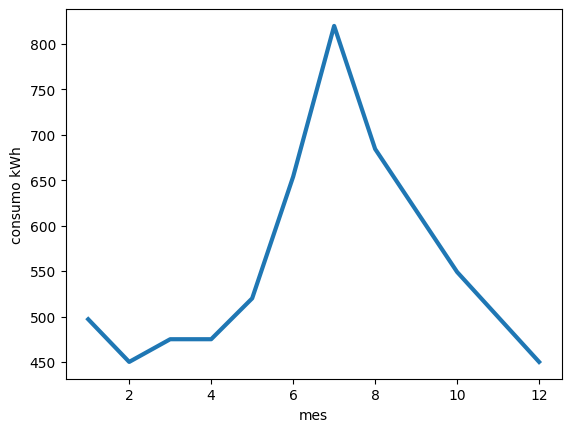

In [52]:
#generate doc
import matplotlib.pyplot as plt


plot = plt.subplot()
#plot_consumption_forecast
plot.plot(forecast['month'],forecast['energy'],linewidth = 3.0)
plot.set_xlabel('mes')
plot.set_ylabel('consumo kWh')
plt.savefig('build/plot_consumption_forecast.png')

In [31]:
# replace pics
plots = {
    "plot_consumption_forecast":"build/plot_consumption_forecast.png"
}
doc.replace_pic('plot_consumption_forecast','build/plot_consumption_forecast.png')

In [32]:
doc.save(f"build/reporte_{project.building.city}_{project.building.name}.docx")